In [37]:
import pandas as pd
from glob import glob
import spacy
import matplotlib.pyplot as plt
from collections import defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

In [ ]:
cd data

In [39]:
nlp = spacy.load('en')

In [4]:
fnames = glob('cases/*txt')

In [4]:
# use spacy to Use spacy to process all cases. Split the documents into sentences and tokens.
sentences = {}
tokens = {}
pos = {}
years = defaultdict(list)

fnames_1 = fnames[:100]
for fname in fnames_1:
    
    # extract docid and year
    docid = fname.split('_')[-1][:-4]
    year = int(fname.split('_')[0].split('/')[-1])
    
    # append to years dictionary
    years[year].append(docid)
    
    text = open(fname).read()
    doc = nlp(text)
    
    # create tokens dictionary
    token_list = [token.text for token in doc]
    tokens[docid] = token_list
    
    # create sentences dictionary
    document = list(doc.sents)
    sentences[docid] = document 
    
    # create POS dictionary
    pos_list = [token.pos_ for token in doc]
    pos[docid] = pos_list
    

In [62]:
# Compute number of sentences, words, and letters for each document
num_sentence = [len(doc_sentence) for doc_sentence in sentences.values()]
num_tokens = [len(doc_token) for doc_token in tokens.values()]
num_letters = [sum([len(word) for word in tokens[doc_name]]) for doc_name in tokens]

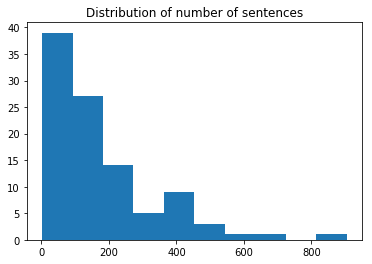

In [73]:
# Report histograms for these statistics
plt.hist(num_sentence)#
plt.title("Distribution of number of sentences")
plt.show()

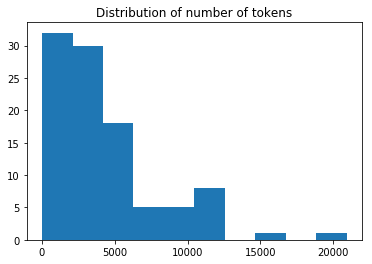

In [74]:
plt.hist(num_tokens)
plt.title("Distribution of number of tokens")
plt.show()

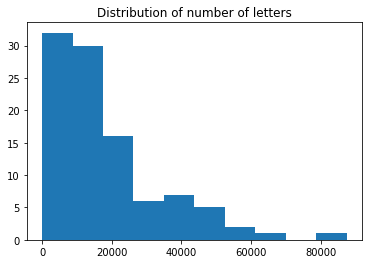

In [75]:
plt.hist(num_letters)
plt.title("Distribution of number of letters")
plt.show()

In [11]:
# count number of nouns, verbs, adjectives in each document
noun_counts = {}
verb_counts = {}
adj_counts = {}

for doc_id in pos:
    noun_counts[doc_id] = sum([word == 'NOUN' for word in pos[doc_id]])
    verb_counts[doc_id] = sum([word == 'VERB' for word in pos[doc_id]])
    adj_counts[doc_id] = sum([word == 'ADJ' for word in pos[doc_id]])

In [34]:
# visualize POS frequency by year

noun_freq_by_year, verb_freq_by_year, adj_freq_by_year = {}, {}, {}

for year in years:
    
    doc_ids = years[year]
    num_nouns, num_verbs, num_adjs = 0, 0, 0
    
    for doc_id in doc_ids:
        num_nouns += noun_counts[doc_id]
        num_verbs += verb_counts[doc_id]
        num_adjs += adj_counts[doc_id]
        
    noun_freq_by_year[year] = num_nouns /(num_nouns + num_verbs + num_adjs)
    verb_freq_by_year[year] = num_verbs /(num_nouns + num_verbs + num_adjs)
    adj_freq_by_year[year] = num_adjs /(num_nouns + num_verbs + num_adjs)

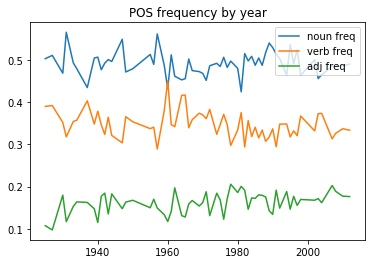

In [37]:
x1, y1 = zip(*sorted(noun_freq_by_year.items()))
x2, y2 = zip(*sorted(verb_freq_by_year.items()))
x3, y3 = zip(*sorted(adj_freq_by_year.items()))

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)

plt.legend(['noun freq', 'verb freq', 'adj freq'], loc='upper right')
plt.title('POS frequency by year')

plt.show()

In [407]:
# normalize the corpus(i.e. remove punctuation)

translator = str.maketrans('','',punctuation) 
stoplist = stopwords.words('english') 
stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()


normalized_tokens = {}

fnames_1 = fnames[:1000]

for fname in fnames_1:
    docid = fname.split('_')[-1][:-4]
    text = open(fname).read()
    
    # convert to lower case
    text_lower = text.lower()
    
    # remove punctuation
    text_nopunc = text_lower.translate(translator)
    
    # token
    tokens = text_nopunc.split()
    
    # replace numbers with #
    norm_numbers = [t if not t.isdigit() else '#' for t in tokens ]
    
    # remove stopwords
    nostop = [t for t in norm_numbers if t not in stoplist]
    
    # stemming
    tokens_stemmed = [stemmer.stem(t) for t in nostop]
    
    # lemmatizing
    tokens_lemmatized = [wnl.lemmatize(t) for t in tokens_stemmed]
    
    normalized_tokens[docid] = tokens_lemmatized

In [ ]:
# discuss your choices about what info to exclude
# First I convert every letter into lower case since the upper or lower case doesn't contain any info about the token.
# Then I chose to remove the punctuation.
# Then I replaced the numbers with #, since the actual number doesn't matter so we treat them as equivalent
# Then I removed the stopwords, since they appear to often and don't have much actual meaning
# Then I did stemming and lemmatization to the tokens

In [408]:
# use the normalized tokens, make a feature set of all trigrams that end in a noun
import nltk
feature_list = []
for docid in normalized_tokens:
    tagged = nltk.pos_tag(normalized_tokens[docid])
    trigrams = ngrams([a for (a,b) in tagged], 3)
    trigrams_pos = ngrams([b for (a,b) in tagged], 3)
    trigrams_filtered = [a for (a,b) in zip(trigrams, trigrams_pos) if (b[-1] == 'NN' or b[-1] == 'NNS')]
    feature_list += trigrams_filtered
feature_set = set(feature_list)

In [412]:
# display the most frequent trigrams
from collections import Counter
top_features = Counter(feature_list)
top_features.most_common(10)

[(('unit', 'state', 'v'), 1953),
 (('v', 'unit', 'state'), 1838),
 (('#', 'unit', 'state'), 704),
 (('#', '#', 'l'), 624),
 (('#', 'district', 'court'), 581),
 (('#', 'suprem', 'court'), 414),
 (('#', '#', 'court'), 384),
 (('#', '2d', 'cir'), 364),
 (('see', 'unit', 'state'), 324),
 (('#', '9th', 'cir'), 322)]

In [413]:
# remove features which appears in too many or too few times
# select 1,000 features
top_features = Counter(feature_list).most_common(1002)[2:]
features_freq = [('_'.join(top_features[i][0]),top_features[i][1]/len(feature_list)) for i in range(1000)]
features = [f[0] for f in features_freq]

In [414]:
# create a list of doc_ids
doc_ids = [fname.split('_')[-1][:-4] for fname in fnames_1]
doc_ids.sort()

feature_df = pd.DataFrame(0, index=doc_ids, columns=features)
feature_df = feature_df.astype('float')
feature_df.head()

,#_unit_state,#_#_l,#_district_court,#_suprem_court,#_#_court,#_2d_cir,see_unit_state,#_9th_cir,cir_cert_deni,judgment_district_court,...,v_natur_resourc,f3d_#_court,question_law_review,#_norrislaguardia_act,ration_basi_review,unit_state_steel,white_mountain_apach,texa_state_court,amend_complaint_alleg,#_#_file
X125RLM003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X12J5IE003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X12OUPI003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X13A37A003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X13A5J0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [415]:
for doc_id in doc_ids:
    ngrams_doc = ['_'.join(x) for x in ngrams(normalized_tokens[doc_id],3)]
    for feature, freq in features_freq:
        if feature in ngrams_doc:
            feature_df.at[doc_id,feature] = freq

In [416]:
feature_df.head()

,#_unit_state,#_#_l,#_district_court,#_suprem_court,#_#_court,#_2d_cir,see_unit_state,#_9th_cir,cir_cert_deni,judgment_district_court,...,v_natur_resourc,f3d_#_court,question_law_review,#_norrislaguardia_act,ration_basi_review,unit_state_steel,white_mountain_apach,texa_state_court,amend_complaint_alleg,#_#_file
X125RLM003,0.000679,0.0,0.00056,0.000399,0.00037,0.000351,0.000312,0.00000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
X12J5IE003,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
X12OUPI003,0.000679,0.0,0.00056,0.000000,0.00000,0.000351,0.000000,0.00031,0.0,0.000000,...,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
X13A37A003,0.000679,0.0,0.00056,0.000399,0.00000,0.000351,0.000000,0.00000,0.0,0.000268,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000016,0.0
X13A5J0003,0.000679,0.0,0.00056,0.000399,0.00037,0.000351,0.000312,0.00031,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [417]:
# Standardize the features to variance one while maintaining sparsity.
from sklearn import preprocessing
X = preprocessing.scale(feature_df,with_mean=False)

In [418]:
# Link the dataframe to the outcome reverse
case_reversed = pd.read_csv('case_reversed.csv')
Y = case_reversed[case_reversed['caseid'].isin(doc_ids)]
Y = Y.sort_values(by = ['caseid'])
Y.head()

,caseid,case_reversed
5069,X125RLM003,1
5089,X12J5IE003,1
1775,X12OUPI003,0
5093,X13A37A003,1
5099,X13A5J0003,1


In [420]:
# split training and testing data
x_train, x_test = X[:667, :], X[667:, :]
y_train, y_test = Y.iloc[:667].case_reversed.values, Y.iloc[667:].case_reversed.values

In [486]:
# train logistic regression
# compute accuracy and F1 for the prediction in the training set and in the test set.
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(x_train, y_train)
# prediction for y_test
y_pred = clf.predict(x_test)

In [444]:
# accuracy for test data
accuracy = clf.score(x_test, y_test)
print(accuracy)

0.5645645645645646


In [446]:
# f1 score for test data
f1_score = f1_score(y_test, y_pred)
print(f1_score)

0.648910411622276


In [447]:
# prediction for y_train
y_pred_train = clf.predict(x_train)

In [448]:
# accuracy for training data
accuracy_train = clf.score(x_train, y_train)
print(accuracy_train)

0.9880059970014993


In [470]:
# f1 score for training data
from sklearn.metrics import f1_score
f1_score = f1_score(y_train, y_pred_train)
print(f1_score)

0.9906759906759907


In [472]:
# Use GridSearchCV() to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C
# Report the best model parameters and score. 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV

logistic_reg = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.1, 0.5, 1, 2, 5],
             }

grid_search = GridSearchCV(logistic_reg, 
                           param_grid, 
                           cv=3) 

grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print(np.abs(grid_search.best_score_))

{'C': 0.1, 'penalty': 'l1'}
0.6026986506746627


In [473]:
# fit the model use best params
clf = LogisticRegression(C=0.1, penalty='l1').fit(x_train, y_train)

In [475]:
y_score = clf.predict(x_test)

In [477]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score)

0.5303195079876997

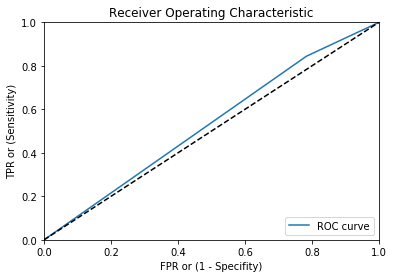

In [484]:
# ROC curve

from sklearn.metrics import roc_curve
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR or (1 - Specifity)')
plt.ylabel('TPR or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [289]:
# Make a new dataframe, where each sentence is a document
fnames_1 = fnames[:100]
sentence_list = []

for fname in fnames_1:

    docid = fname.split('_')[-1][:-4] 
    text = open(fname).read()
    sent = nltk.sent_tokenize(text)
    sentence_list.extend(sent)
    
df = pd.DataFrame({'sentence':sentence_list})

In [290]:
df.head()

,sentence
0,"STONE , Circuit Judge."
1,This is an action to recover reparation for a ...
2,The matter was first presented to the Intersta...
3,The railway having failed to pay the amount fo...
4,From the judgment according reparation this ap...


In [295]:
# Compute vader compound sentiment scores for each sentence
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import operator
sid = SentimentIntensityAnalyzer()

sent = {}
for sentence in df['sentence']:
    ss = sid.polarity_scores(sentence)
    sent[sentence] = ss['compound']
    
sorted_sent = sorted(sent.items(), key=operator.itemgetter(1))

In [303]:
# top 10 highest sentiment sentences
for sentence, score in sorted_sent[-10:]:
    print("%s: %s" % (sentence, score))

The critical paragraph provides in part that if any claim for worker's compensation benefits "shall hereafter be filed and be successful, and the amounts ordered to be paid are found to be a lien against the consideration paid herein, then any employer or its insurance carrier paying or ordered to pay such compensation benefits to any Releasor shall first be given credit for the consideration paid to Releasors under this agreement, less reasonable costs of collection, and shall make no payment of any compensation benefits to any Releasor until the consideration paid to Releasors under this agreement is exhausted.": 0.9501
The facts hereinafter stated were stipulated and are set forth substantially as found in the petitioner's brief: On December 24, 1913, Charles Henry Sanford, by a single trust indenture created certain trusts naming Guaranty Trust Company of New York as Trustee, and on that date and at various times thereafter transferred certain property to the Trustee.: 0.9509
In af

In [305]:
# lowest 10 sentiment sentences
for sentence, score in sorted_sent[:10]:
    print("%s: %s" % (sentence, score))

2 The plaintiffs in the Washington case contended for physician-assisted suicide for the terminally-ill, but the panel majority found that the statute prohibiting suicide promotion furthered the following: the interest in denying to physicians "the role of killers of their patients"; the interest in avoiding psychological pressure upon the elderly and infirm to consent to death; the interest of preventing the exploitation of the poor and minorities; the interest in protecting handicapped persons against societal indifference; the interest in preventing the sort of abuse that "has occurred in the Netherlands where legal guidelines have tacitly allowed assisted suicide or euthanasia in response to a repeated request from a suffering, competent patient.": -0.9828
In adjudicating the plaintiff's antitrust claim, the district court in its thorough opinion initially evaluated Bell Atlantic's argument that the plaintiff did not have standing to bring an antitrust action because the only damag

In [355]:
# Use TfidfVectorizer to compute tf-idf frequencies for each sentence
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 500)
X_tfidf = tfidf.fit_transform(df['sentence'])

In [327]:
# compute cosine similarities between all sentences
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X_tfidf)
sim.shape

(17221, 17221)

In [363]:
# example pairs of and very dissimilar sentences
import numpy as np
a, b = np.where((sim < 0.05))
print(df.loc[a[0]].sentence)
print(df.loc[b[0]].sentence)

 STONE , Circuit Judge.
This is an action to recover reparation for a freight overcharge.


In [370]:
# example pairs of very similar sentences
a, b = np.where((sim>0.95))
sim_pairs = [(x,y) for x, y in zip(a,b) if x != y]
print(df.loc[sim_pairs[0][0]].sentence)
print(df.loc[sim_pairs[0][1]].sentence)

 STONE , Circuit Judge.
 L. HAND , Circuit Judge.


In [316]:
# Use k-means clustering to assign the sentences into 20 clusters
# List 5 example sentences from each cluster
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20,n_jobs=-1)
km.fit(X_tfidf)
doc_clusters = km.labels_.tolist()
df['cluster'] = doc_clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [322]:
for i in range(20):
    print('============= examples for cluster ' + str(i))
    print(df[df['cluster'] == i]['sentence'][:5])

============= examples for cluster 0
111    Nor is there any substantial difference in the...
112    The answer here is indeed doubtful, but on the...
212    The court explained that those cases simply "d...
360    First Question and Specification of Error In h...
472    As we have held, "[t]he plea agreement and the...
Name: sentence, dtype: object
============= examples for cluster 1
1     This is an action to recover reparation for a ...
2     The matter was first presented to the Intersta...
8     The tariffs covering rates from the points of ...
12    It is for this difference in charge that this ...
13    The issues here involved have to do with the p...
Name: sentence, dtype: object
============= examples for cluster 2
187    03-73597, 2005 WL 1529574 , at *6 (E.D.Mich.
234                                       at 1123 .
265                                        at 641 .
293                 95-382 , at 5 (emphasis added).
675                                         at 52 .
Name